# Your first neural network (PyTorch implementation)

In this project, you'll build your first neural network and use it to predict daily bike rental ridership.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data.

In [2]:
data_path = './Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

## Checking out the data

In [3]:
rides.head(10)  # return first a few rows

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


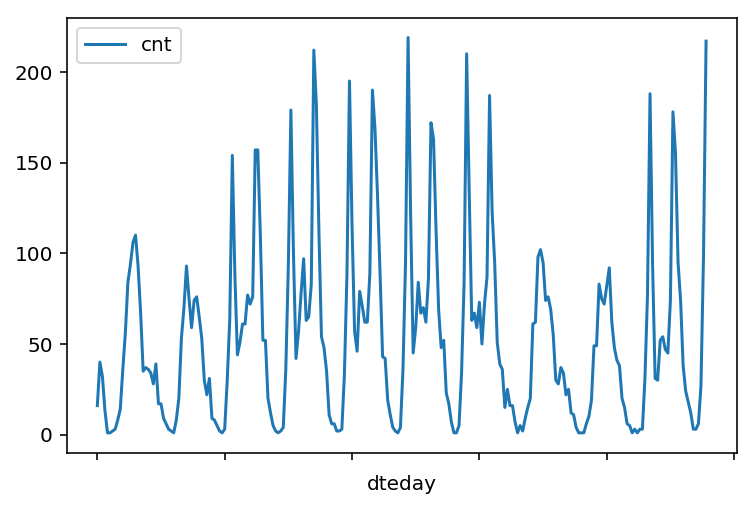

In [4]:
rides[:10*24].plot(x='dteday', y='cnt')  # show the number of bike riders over the first 10 days or so

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
cat_field_list = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for e in cat_field_list:
    cat_cols = pd.get_dummies(rides[e], prefix=e, drop_first=False)  # generate binary categorical variables
    rides = pd.concat([rides, cat_cols], axis=1)
    
drop_field_list = ['instant', 'dteday', 'season', 'weathersit', 'atemp', 'mnth', 'workingday', 'hr', 'weekday']
data = rides.drop(drop_field_list, axis=1)  # drop the fields
data.head(10)

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0.24,0.75,0.0896,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0.22,0.80,0.0000,2,0,2,1,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0.20,0.86,0.0000,1,2,3,1,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0.24,0.75,0.0000,1,7,8,1,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0.32,0.76,0.0000,8,6,14,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
feature_list = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
feature_mean_dict = {}
feature_std_dict = {}

for e in feature_list:
    mean, std = data[e].mean(), data[e].std()
    feature_mean_dict[e], feature_std_dict[e] = mean, std
    data[e] = (data[e] - mean) / std
    
# for e in feature_list:
#     print('mean of {}: {}, std of {}: {}'.format(e, data[e].mean(), e, data[e].std()))
    
data.head(10)

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,-1.334609,0.636351,-0.821460,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,-1.438475,0.895513,-1.553844,-0.683018,-1.016052,-1.033495,1,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,-1.542341,1.206507,-1.553844,-0.703300,-1.002838,-1.027981,1,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,-1.334609,0.636351,-1.553844,-0.703300,-0.969804,-1.000416,1,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,-0.919146,0.688184,-1.553844,-0.561326,-0.976411,-0.967338,1,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
test_data = data[-21*24:]  # last 21 days for test
data = data[:-21*24]  # remove the test data

# separate the data into features and targets
target_field_list = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_field_list, axis=1).values, np.expand_dims(data['cnt'].values, 1)
test_features, test_targets = test_data.drop(target_field_list, axis=1).values, np.expand_dims(test_data['cnt'].values, 1)

# split training and validation
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]  # last 60 days (or so) in data for validation

## Time to build the network (with PyTorch)

<img src="assets/neural_network.png" width=300px>

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
from torch.autograd import Variable
import copy

device = torch.device('cpu')  # run on CPU
# device = torch.device('cuda')  # run on GPU

# hyperparameters
n_epoch = 20
batch_size = 128
n_in = train_features.shape[1]
n_hidden = 32
n_out = 1
learning_rate = 1e-2
print_freq = 100

# set up sequential model
model = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, n_out)
).to(device)

# MSE loss function for regression
loss_func = torch.nn.MSELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# set up data loaders for training, validation datasets
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_features).float(), torch.from_numpy(train_targets).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_features).float(), torch.from_numpy(val_targets).float())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataset_loaders = {'train' : train_loader, 'val' : val_loader}
dataset_sizes = {'train' : len(train_dataset), 'val' : len(val_dataset)}

# start training
min_val_loss = float('inf')
best_model = copy.deepcopy(model.state_dict())
for i_epoch in range(n_epoch):
    print('Epoch {}/{}'.format(i_epoch+1, n_epoch))
    print('-' * 20)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # set model to training mode
        else:
            model.eval()   # set model to evaluate mode
            
        running_loss = 0.0
    
        for i, (features, targets) in enumerate(dataset_loaders[phase]):
            features = features.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # forward
                outputs = model(features)
                loss = loss_func(outputs, targets)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * features.size(0)
            
            if (i + 1) % print_freq == 0:
                print('{}: Step {}/{}, Loss = {:.4f}'.format(phase, i+1, (dataset_sizes[phase]//batch_size)+1, running_loss/((i+1)*features.size(0))))
        
        epoch_loss = running_loss / dataset_sizes[phase]
        
        # statistics after each epoch
        print('{}: Step {}/{}, Loss = {:.4f}'.format(phase, i+1, (dataset_sizes[phase]//batch_size)+1, epoch_loss))
        
        # update the best model that yields the minimum
        if phase == 'val' and epoch_loss < min_val_loss:
            print('New best model found: validation loss is reduced from {:.4f} to {:.4f}'.format(min_val_loss, epoch_loss))
            min_val_loss = epoch_loss
            best_model = copy.deepcopy(model.state_dict())

# load the best model
model.load_state_dict(best_model)

Epoch 1/20
--------------------
train: Step 100/121, Loss = 0.2997
train: Step 121/121, Loss = 0.2686
val: Step 12/12, Loss = 0.2220
New best model found: validation loss is reduced from inf to 0.2220
Epoch 2/20
--------------------
train: Step 100/121, Loss = 0.0770
train: Step 121/121, Loss = 0.0753
val: Step 12/12, Loss = 0.1530
New best model found: validation loss is reduced from 0.2220 to 0.1530
Epoch 3/20
--------------------
train: Step 100/121, Loss = 0.0616
train: Step 121/121, Loss = 0.0613
val: Step 12/12, Loss = 0.1578
Epoch 4/20
--------------------
train: Step 100/121, Loss = 0.0572
train: Step 121/121, Loss = 0.0569
val: Step 12/12, Loss = 0.1403
New best model found: validation loss is reduced from 0.1530 to 0.1403
Epoch 5/20
--------------------
train: Step 100/121, Loss = 0.0533
train: Step 121/121, Loss = 0.0533
val: Step 12/12, Loss = 0.1289
New best model found: validation loss is reduced from 0.1403 to 0.1289
Epoch 6/20
--------------------
train: Step 100/121, L

/Users/zlc/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


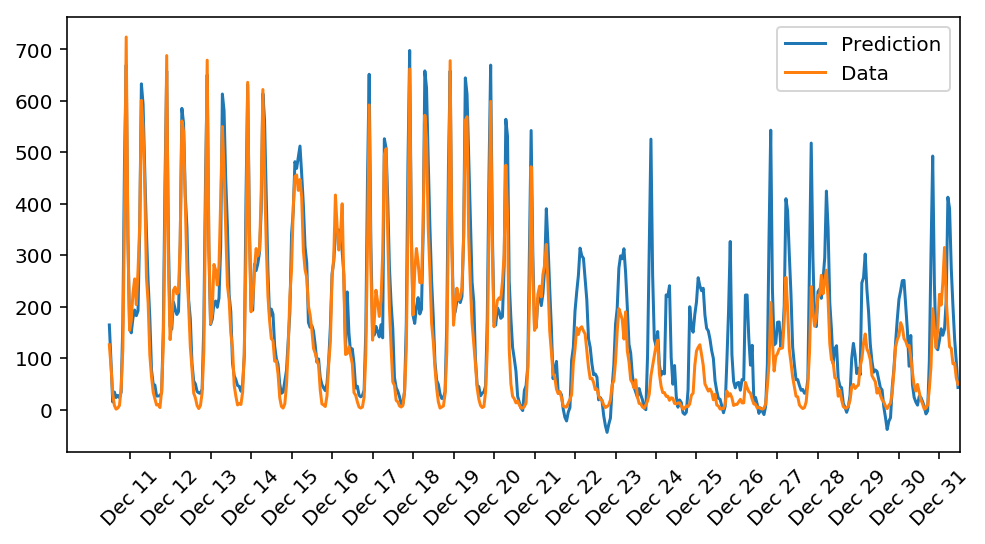

In [9]:
# prediction only, without the need of tracking gradient
with torch.no_grad():
    predictions = model(torch.from_numpy(test_features).float())
    predictions = predictions.numpy()

fig, ax = plt.subplots(figsize=(8,4))
mean, std = feature_mean_dict['cnt'], feature_std_dict['cnt']
ax.plot(predictions * std + mean, label='Prediction')
ax.plot(test_targets * std + mean, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)